In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import norm, skew #for some statistics

Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
# ID is dropped once because it is unnecessary for model prediction

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [4]:
print ("Size of train data after dropping Id: {}" .format(train.shape))
print ("Size of test data after dropping Id: {}" .format(test.shape))

Size of train data after dropping Id: (1460, 80)
Size of test data after dropping Id: (1459, 79)


## Correspondence of outliers
- Excluding more than 4000 because data creators recommend taking out 'GrLivArean' outliers.
- I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.

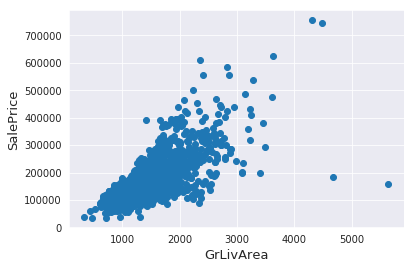

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [6]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check correlation
- Check for correlations above 0.5

In [7]:
# Find correlations with the target and sort
correlations = train.corr()['SalePrice'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.sort_values(ascending=False).head(15))
print('\nMost Negative Correlations:\n', correlations.sort_values().head(15))

Most Positive Correlations:
 SalePrice       1.000000
OverallQual     0.795774
GrLivArea       0.734968
TotalBsmtSF     0.651153
GarageCars      0.641047
1stFlrSF        0.631530
GarageArea      0.629217
FullBath        0.562165
TotRmsAbvGrd    0.537769
YearBuilt       0.523608
YearRemodAdd    0.507717
GarageYrBlt     0.487156
MasVnrArea      0.482719
Fireplaces      0.469862
BsmtFinSF1      0.409384
Name: SalePrice, dtype: float64

Most Negative Correlations:
 KitchenAbvGr    -0.135946
EnclosedPorch   -0.128646
MSSubClass      -0.084276
OverallCond     -0.077948
YrSold          -0.028882
LowQualFinSF    -0.025625
MiscVal         -0.021203
BsmtHalfBath    -0.016881
BsmtFinSF2      -0.011422
3SsnPorch        0.044568
MoSold           0.046124
PoolArea         0.099490
ScreenPorch      0.111415
BedroomAbvGr     0.168245
BsmtUnfSF        0.214460
Name: SalePrice, dtype: float64


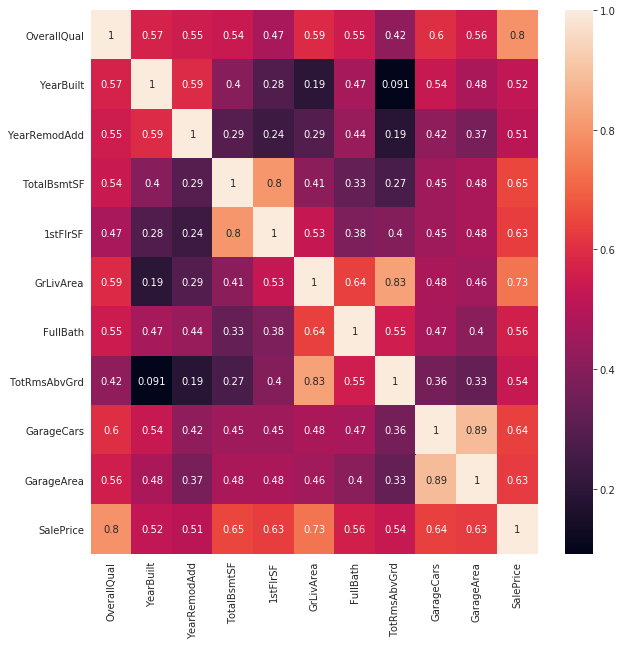

In [8]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True)

- It is clear that there is a strong correlation between the following items and SalePrice

 OverallQual, GrLivArea, TotalBsmtSF, GarageCars, GarageArea, 1stFlrSF
 
 ---
- There is a strong correlation between GarageCars and GarageArea in the above.
---
- High correlation between TotalBSMTSF (basement area) and 1stFlrSF (first floor area)

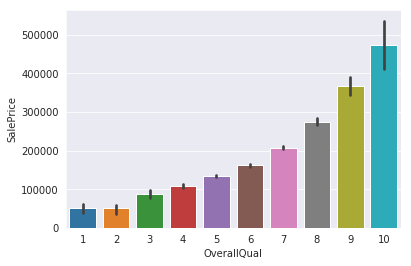

In [9]:
sns.barplot(train.OverallQual,train.SalePrice)

- You can see that the price is clearly rising by OverallQual (house condition)

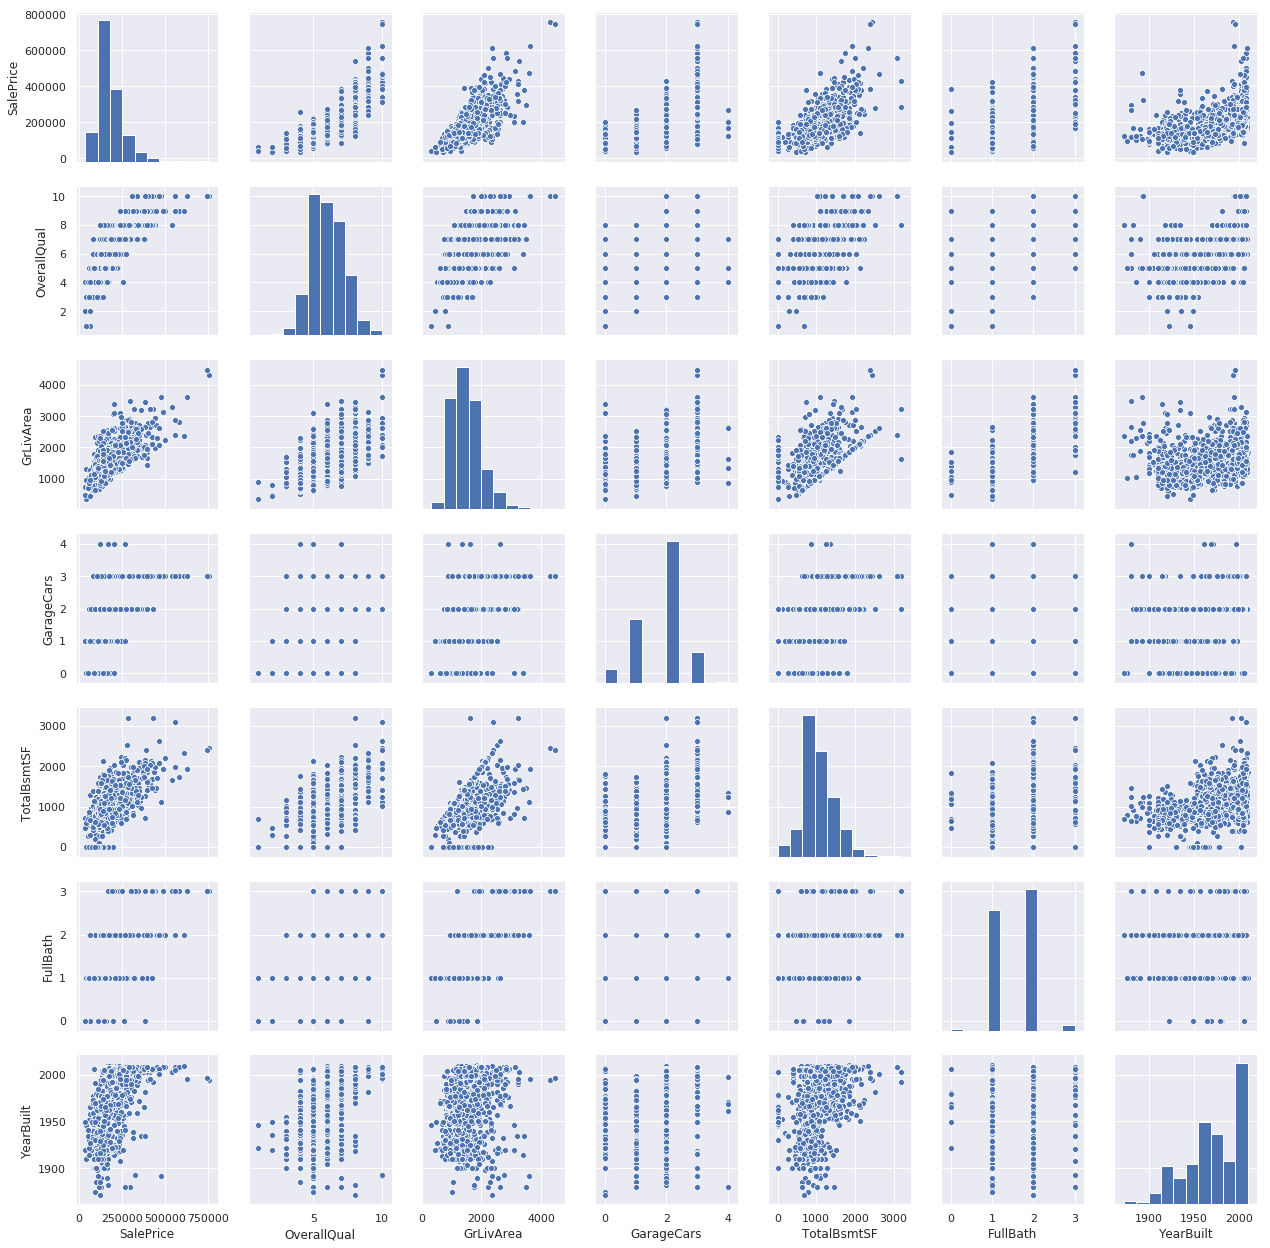

In [10]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

- Scatter plots show that the shapes of TotalBsmtSF (underground area) and GrLivArea (Above ground living area square feet) are a bit strange

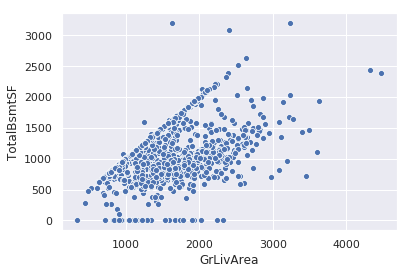

In [11]:
sns.scatterplot(train.GrLivArea,train.TotalBsmtSF)

- TotalBsmtSF and GrLivArea are often the same, and it is rare that the value of TotalBsmtSF can come to the value of GrLivArea

## Find out the relationship between SalePrice and Feature in more detail

### Transformation of objective variable

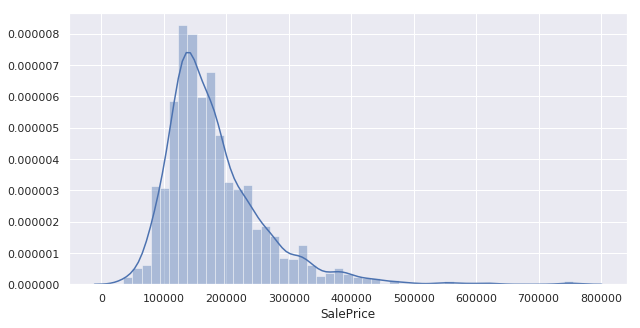

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(train['SalePrice'])
plt.show()

When the objective variable (SalePrice) is generated in the histogram, it can be seen that the distribution is not normal. Therefore, it is logarithmically converted (it reduces the fluctuation by reducing the fluctuation of the value)

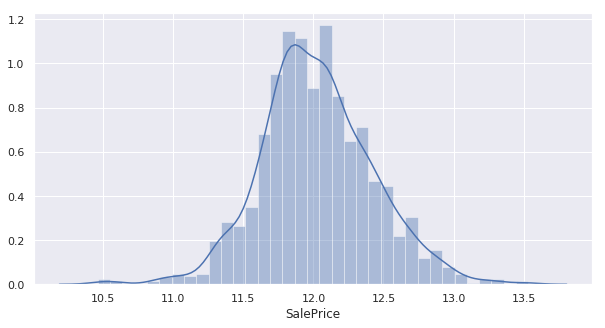

In [13]:
# Perform logarithmic calculation
# Reduce variation in numbers and deviations

train['SalePrice'] = np.log1p(train['SalePrice'])

plt.figure(figsize=(10,5))
sns.distplot(train['SalePrice'])
plt.show()

## Feature engineering

In [14]:
# Combine all data once
# See feature quantities in all data including tests (eg. median value when complementing missing values)
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


## Missing values


### Checking for missing values

In [15]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# See top 30 only 
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

Text(0.5, 1.0, 'Percent missing data by feature')

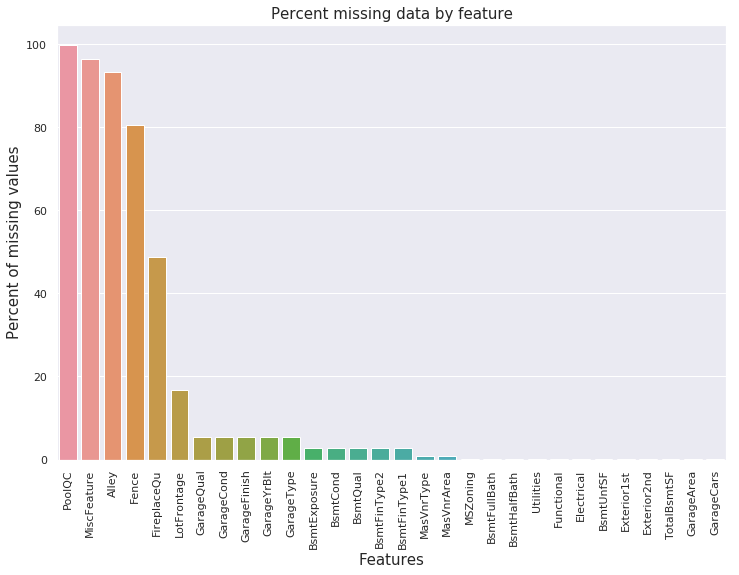

In [16]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [17]:
# View PoolQC (pool quality) with the most missing values
all_data.PoolQC.loc[all_data.PoolQC.notnull()]

197     Ex
809     Fa
1169    Gd
1181    Ex
1384    Fa
1421    Gd
1972    Ex
2571    Ex
2708    Gd
Name: PoolQC, dtype: object

### Filling Missing Values

In [18]:
# In case of null part in PoolQC is No Pool (there is no pool). 
# This time, fill the null part with the string None

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [19]:
# Null in MiscFeature (other feature) is no misc feature
# Alley, Fence, and FireplaceQ are similar.

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage is likely to be related to the Neighborhood, so store the median per Neighborhood in the missing value

In [20]:
# Grouping by Neighborhood and Check the LotFrontage. Most of the grouping has similar areas

grouped_df = all_data.groupby('Neighborhood')['LotFrontage']

for key, item in grouped_df:
    print(key,"\n")
    print(grouped_df.get_group(key))
    break


Blmngtn 

219     43.0
229     43.0
385     43.0
443     53.0
465      NaN
558      NaN
596     53.0
638     53.0
789     43.0
850      NaN
981     43.0
1003    43.0
1018    43.0
1022    43.0
1125    53.0
1392    53.0
1413    51.0
1481    43.0
1683    43.0
1982     NaN
1983     NaN
1984    53.0
2318     NaN
2319    53.0
2669    43.0
2670     NaN
2671     NaN
2672    43.0
Name: LotFrontage, dtype: float64


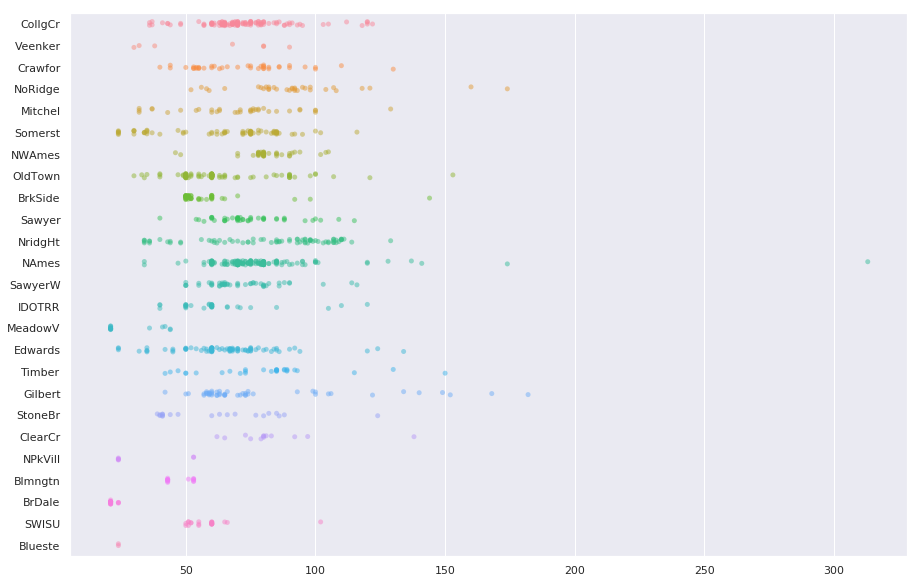

In [21]:
plt.figure(figsize=(15, 10))
sns.stripplot(y = train.Neighborhood.values, x = train.LotFrontage.values, 
              jitter=0.1, alpha=0.5, orient='h')

In [22]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [23]:
# Fill in GarageType, GarageFinis, GarageQual, GarageCond with None

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [24]:
abc = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','GarageYrBlt', 'GarageArea', 'GarageCars']
all_data.groupby('GarageType')[abc].count()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
GarageType,,,,,,,
2Types,23,23,23,23,23,23,23
Attchd,1722,1722,1722,1722,1722,1722,1722
Basment,36,36,36,36,36,36,36
BuiltIn,185,185,185,185,185,185,185
CarPort,15,15,15,15,15,15,15
Detchd,779,779,779,779,777,778,778
None,157,157,157,157,0,157,157


In [25]:
# Fill with 0
# GarageYrBlt, GarageArea and GarageCars 

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [26]:
# Fill with 0
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [27]:
# fill with None
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 
# Because that means that there is no feature related to the basement

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [28]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [29]:
# MSZoning is filled with RL because RL is the most frequent value

all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [30]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [31]:
#Utilities is the same AllPub for most values, so there is not much meaning, so delete this column

all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [32]:
all_data = all_data.drop(['Utilities'], axis=1)

In [33]:
all_data['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [34]:
# Fill functional with most common value.

all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [35]:
# Because it is a category type, fill in with the mode 
# Electrical,KitchenQual, Exterior1st, Exterior2nd,  SaleType

mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [36]:
# MSSubClass means that NA is not a building class, so it will be filled in with None

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

### Check for missing values

In [37]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### Correspondence of numeric category value

In [38]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [39]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Label Encoding

In [40]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


As area-related values ​​greatly affect real estate prices, create a new feature value for the total area.

In [41]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# https://www.kaggle.com/katotaka/prediction-house-prices-eda
all_data["Interaction"] = all_data["TotalSF"] * all_data["OverallQual"]

### See bias of features other than object type

In [42]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


When dealing with actual data, there is not a normal distribution. 
Therefore, use Box-Cox transformation to approximate normal distribution

In [43]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 60 skewed numerical features to Box Cox transform


# Dummy-Encoding
Convert categorical values ​​with one-hotencoding

In [44]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 221)

# Create model
1. Importing Libraries

2. We will use models
    - Lasso
    - Ridge
    - Gradient Boosting
    - XGBoosting
    - LightGBM
3. Find the Cross Validation Score.

4. Calculate the mean of all model's prediction.
5. Submit the CSV file.

In [45]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 221)

### Import libraries

In [46]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### cross validation

In [47]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Ridge Regression

In [48]:
Ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(Ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1158 (0.0081)



### Lasso Regression

In [49]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1114 (0.0073)



### Gradient Boosting Regression

In [50]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1169 (0.0061)



### XGBoost

In [51]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1178 (0.0054)



### LightGBM

In [52]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1169 (0.0070)



In [53]:
LassoMd = lasso.fit(train.values,y_train)
RidgeMd = Ridge.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)
XGBMd = model_xgb.fit(train.values, y_train)
LGBMd = model_lgb.fit(train.values, y_train)

### Calculate the average of all predicted values

In [54]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(RidgeMd.predict(test.values)) 
           + np.expm1(GBoostMd.predict(test.values)) + np.expm1(XGBMd.predict(test.values))  
           + np.expm1(LGBMd.predict(test.values)) ) / 5
finalMd

array([121876.02652199, 162786.44029177, 185467.52275933, ...,
       167862.11512638, 114266.08783379, 222071.59211251])

### Submission

In [55]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)